In [1]:
!pip install chainer==7.7.0

     |████████████████████████████████| 11.2 MB 7.0 MB/s 
  Created wheel for chainer: filename=chainer-7.7.0-py3-none-any.whl size=967522 sha256=b9ecf1a07e5c28e4d167d6115d5b72b4c36869879968ac4ded90f5115b30c5ea
  Stored in directory: /root/.cache/pip/wheels/4f/c2/ca/e46a1181cc92ebe6e2d117a5cd29da5bcfc8464e00edb2cac0
Successfully built chainer


In [2]:
import chainer

In [3]:
import cv2
import csv
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image 

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd /content/
!rm -rf hyperface
!git clone https://github.com/alvaro-neira/hyperface.git --branch colab
%cd hyperface/
!git fetch --all
!git pull origin colab


/content
Cloning into 'hyperface'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 285 (delta 43), reused 40 (delta 19), pack-reused 218
Receiving objects: 100% (285/285), 9.08 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/content/hyperface
Fetching origin
From https://github.com/alvaro-neira/hyperface
 * branch            colab      -> FETCH_HEAD
Already up to date.


In [6]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [8]:
pre_trained = '/content/drive/MyDrive/ai/model_epoch_190'
config_path = '/content/hyperface/config.json'


In [10]:
print(short_hyperface(config_path,'/content/drive/MyDrive/ai/faces1/tv24horas_2021_12_07_01_face1.png',pre_trained))

Male, detection=0.9786882400512695


In [11]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [15]:
import chainer

import cv2
import os
import numpy as np

import config
from drawing import draw_pose, draw_gender, draw_detection, draw_landmark
import models

# Disable type check in chainer
os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def frame_detect(img):
    # Load config
    config.load(config_path)

    # Define a model
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(pre_trained, model)

    xp = np

    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        exit()
    frame = img.copy()
    frame = frame.astype(np.float32) / 255.0  # [0:1]
    frame = cv2.resize(frame, models.IMG_SIZE)
    frame = cv2.normalize(frame, None, -0.5, 0.5, cv2.NORM_MINMAX)
    frame = np.transpose(frame, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([frame])
    x = chainer.Variable(imgs)  # , volatile=True)

    y = model(x)

    # Chainer.Variable -> np.ndarray
    imgs = _cvt_variable(y['img'])
    detections = _cvt_variable(y['detection'])
    landmarks = _cvt_variable(y['landmark'])
    visibilities = _cvt_variable(y['visibility'])
    poses = _cvt_variable(y['pose'])
    genders = _cvt_variable(y['gender'])

    # Use first data in one batch
    frame = imgs[0]
    detection = detections[0]
    landmark = landmarks[0]
    visibility = visibilities[0]
    pose = poses[0]
    gender = genders[0]

    frame = np.transpose(frame, (1, 2, 0))
    frame = frame.copy()
    frame += 0.5  # [-0.5:0.5] -> [0:1]
    detection = (detection > 0.5)
    gender = (gender > 0.5)

    # Draw results
    draw_detection(frame, detection)
    landmark_color = (0, 1, 0) if detection == 1 else (0, 0, 1)
    draw_landmark(frame, landmark, visibility, landmark_color, 0.5)
    draw_pose(frame, pose)
    draw_gender(frame, gender)
    return 255 * cv2.resize(frame, (640, 360), interpolation=cv2.INTER_AREA)


def test():
    lena = frame_detect(cv2.imread('/Users/aneira/hyperface/sample_images/lena_face.png'))
    cv2.imshow('result', lena / 255)
    cv2.waitKey(0)
    cv2.imwrite('/Users/aneira/hyperface/sample_images/lena_face_result3.png', lena, [cv2.IMWRITE_PNG_COMPRESSION, 0])


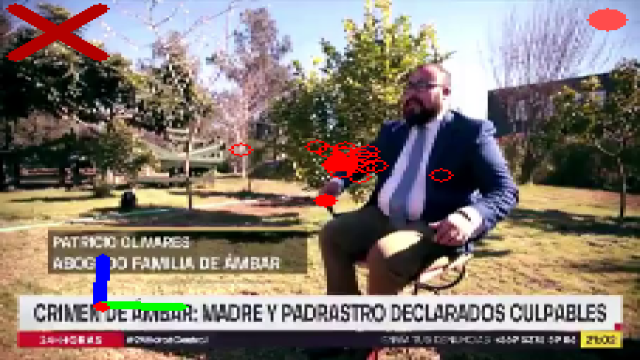

frame_11700.png





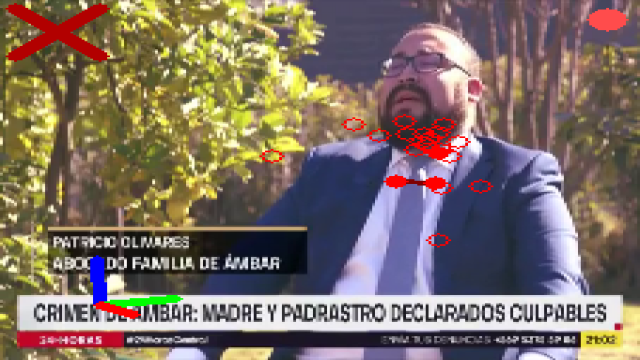

frame_12000.png





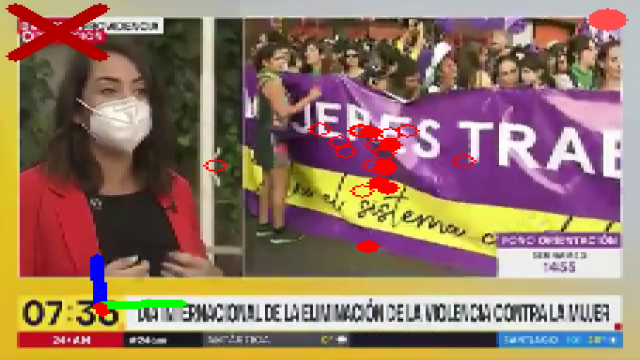

frame_600.png





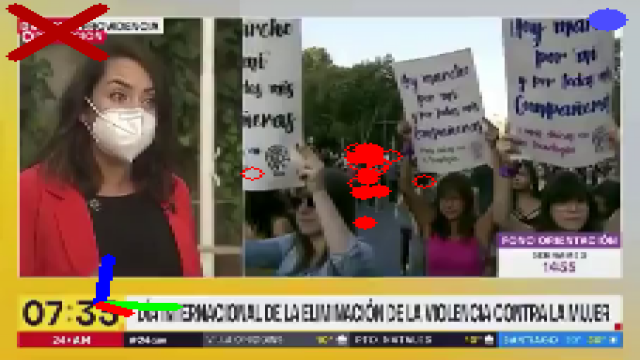

frame_0.png





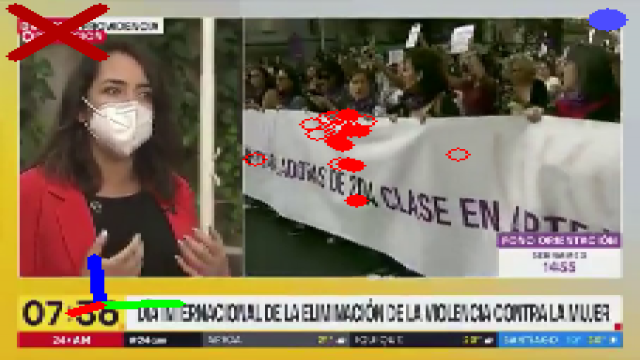

frame_900.png





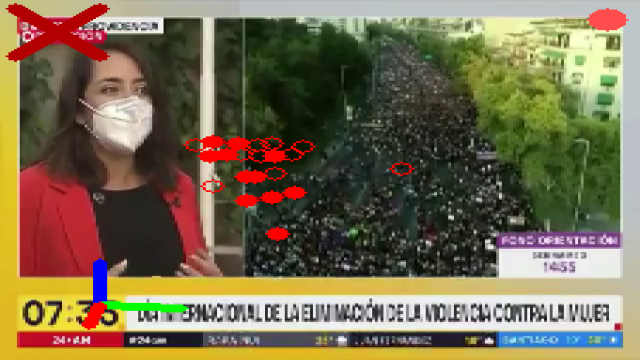

frame_300.png





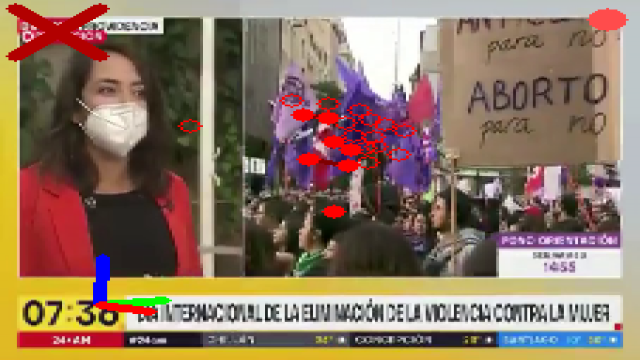

frame_1800.png





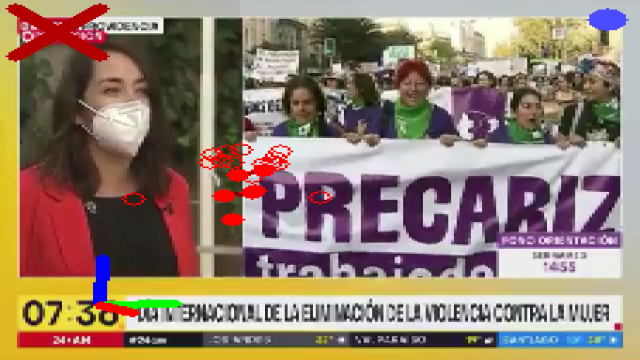

frame_1500.png





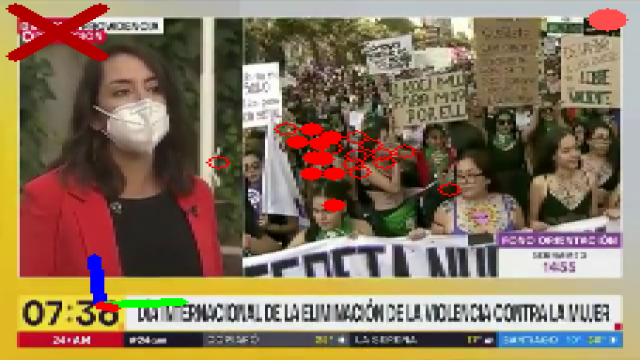

frame_1200.png





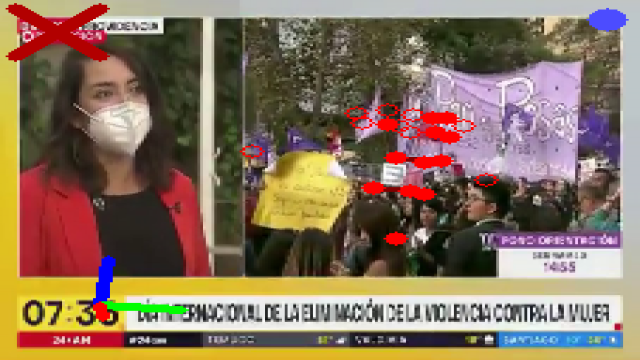

frame_2100.png





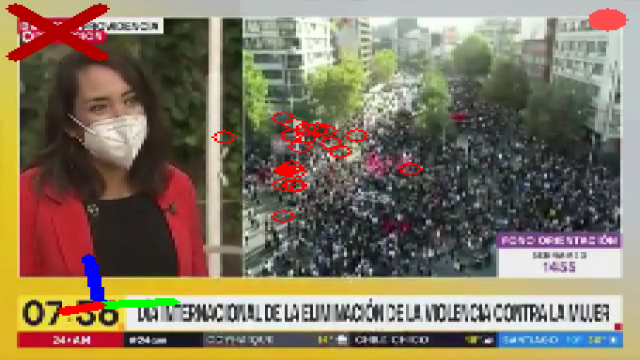

frame_2700.png





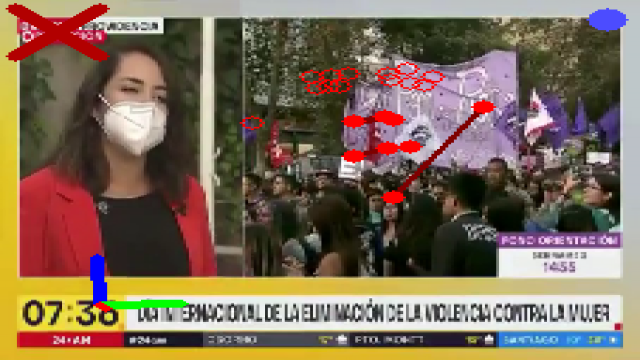

frame_2400.png





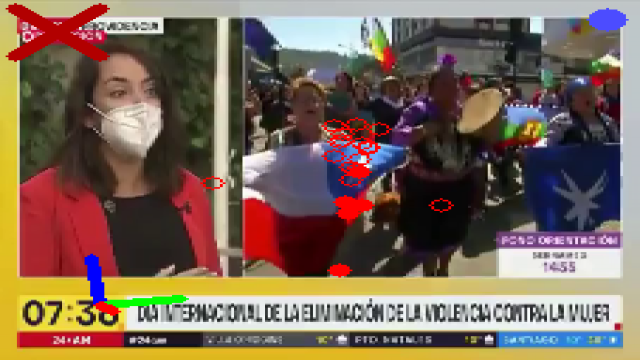

frame_3000.png





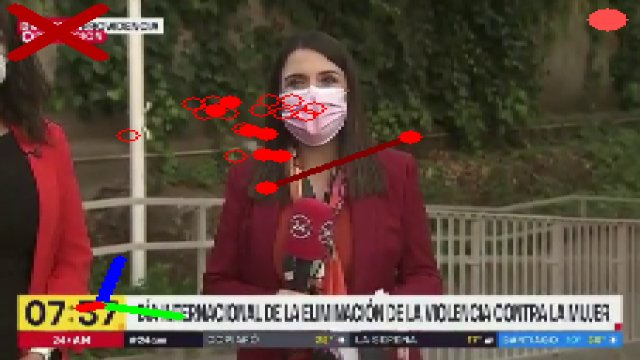

frame_4200.png





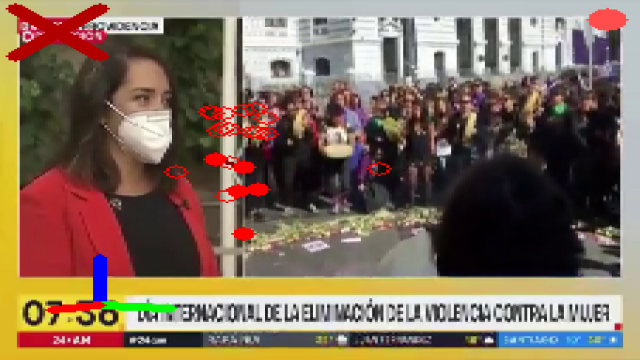

frame_3300.png





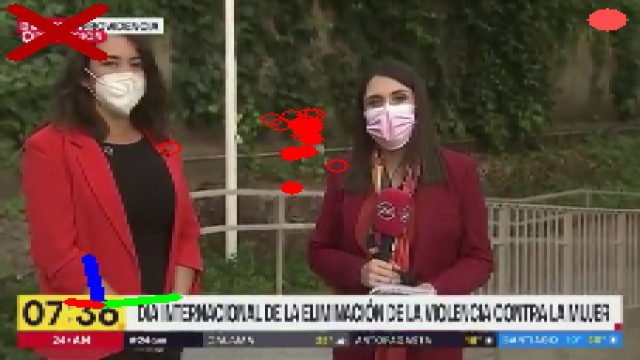

frame_3900.png





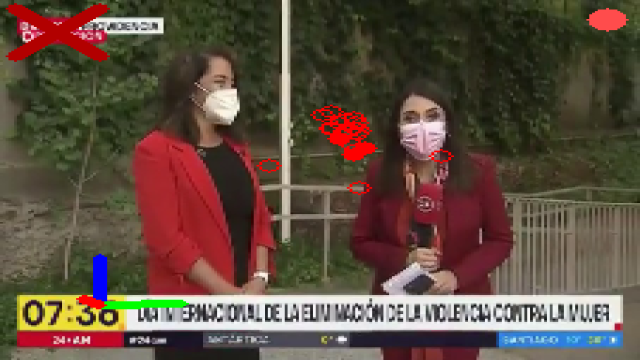

frame_3600.png





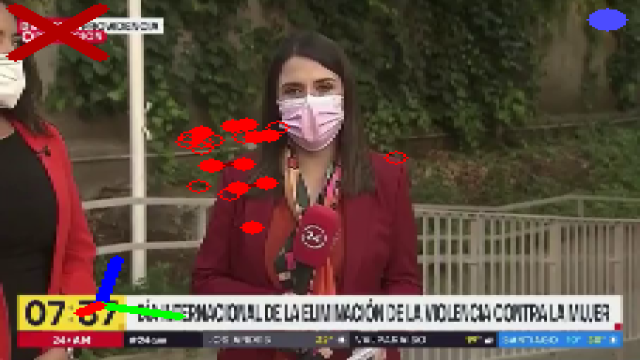

frame_4500.png





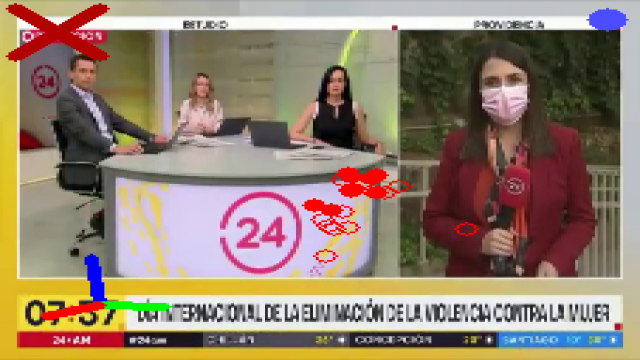

frame_4800.png





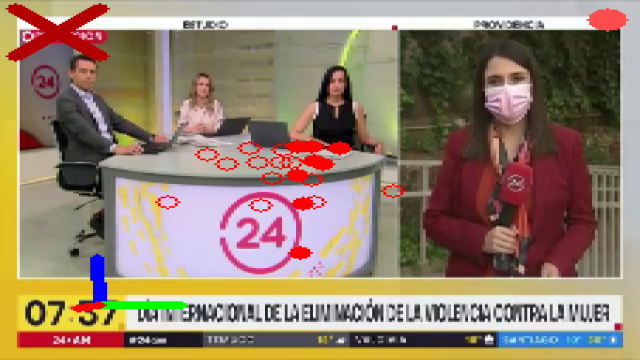

frame_5100.png





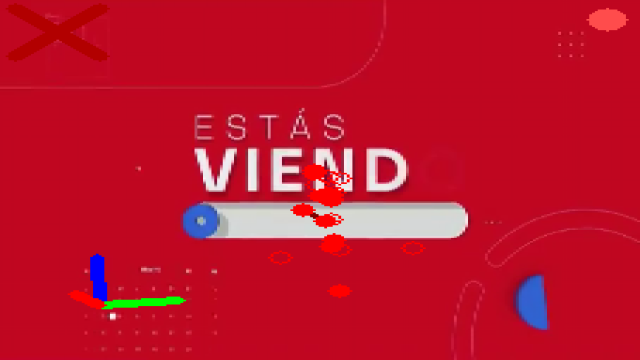

frame_5700.png





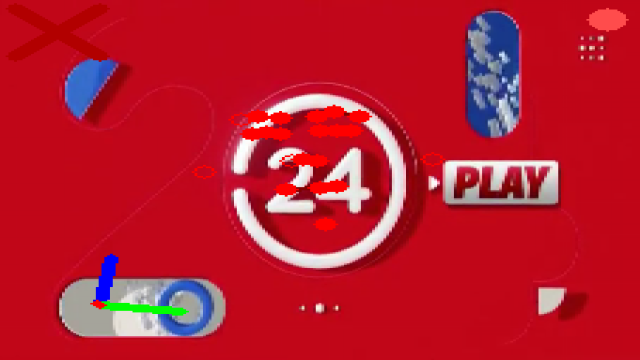

frame_6000.png





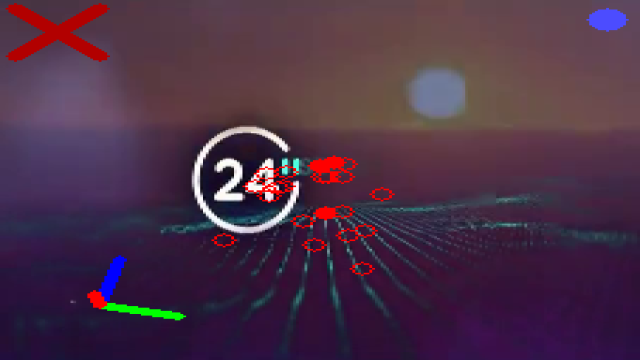

frame_6300.png





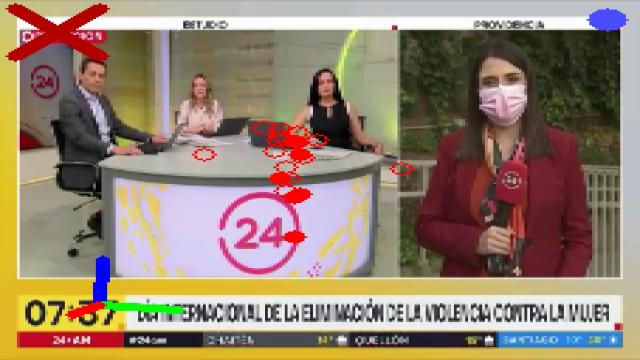

frame_5400.png





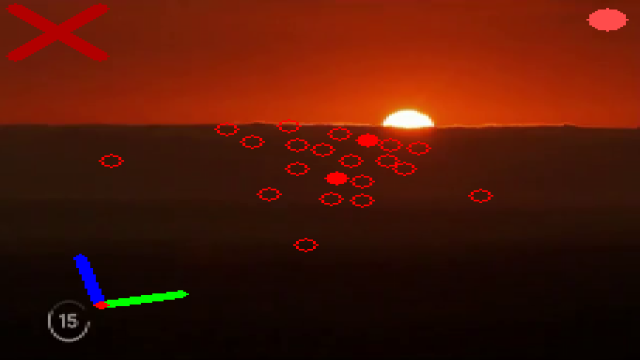

frame_7200.png





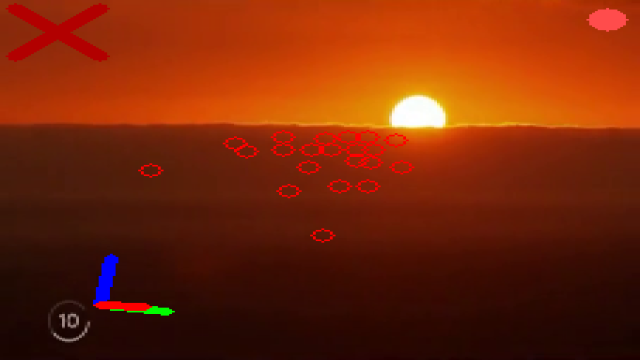

frame_6900.png





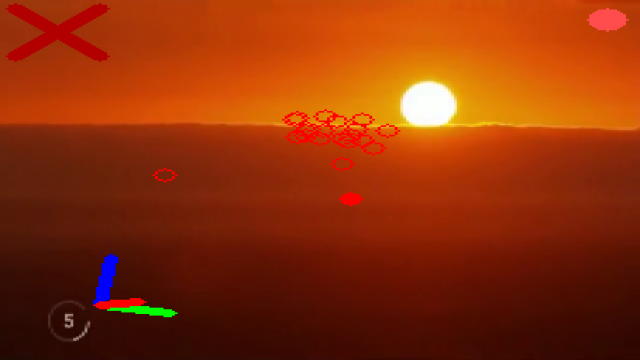

frame_6600.png





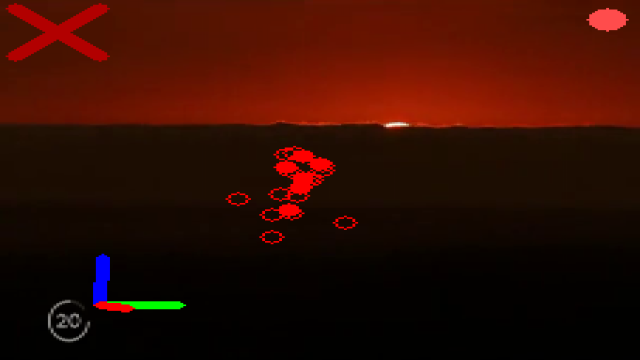

frame_7500.png





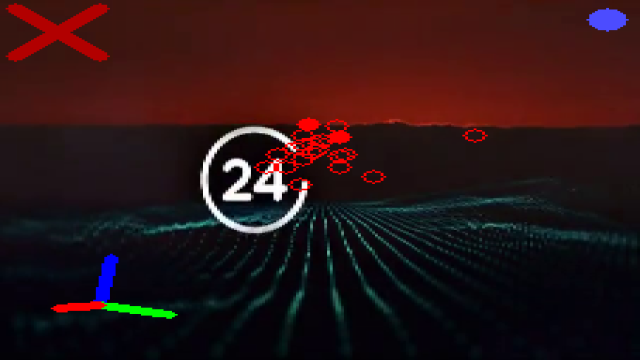

frame_7800.png





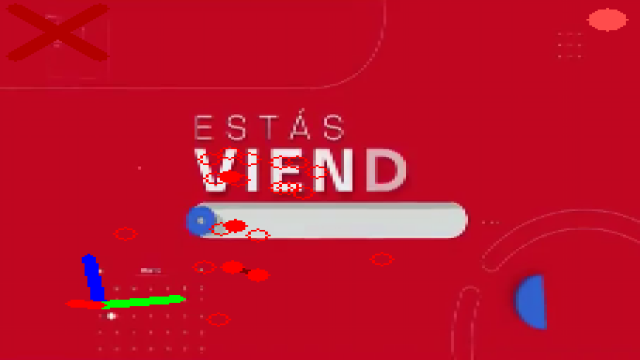

frame_8100.png





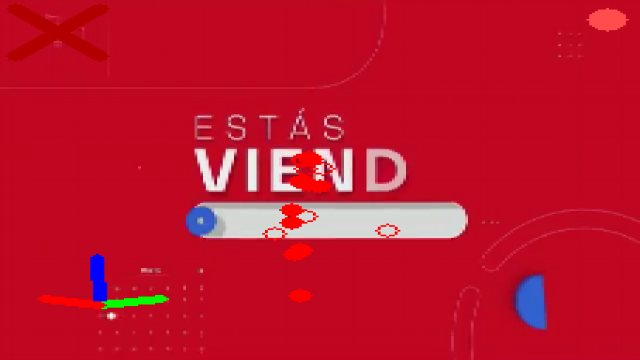

frame_8700.png





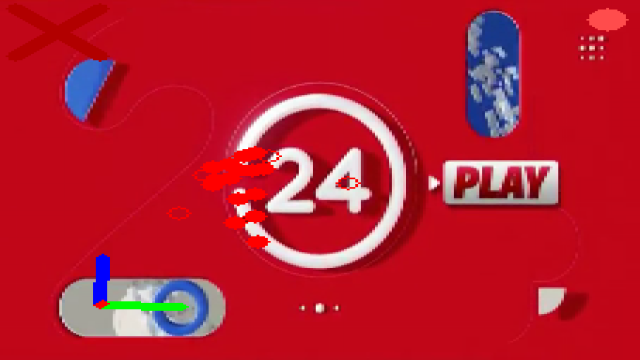

frame_9000.png





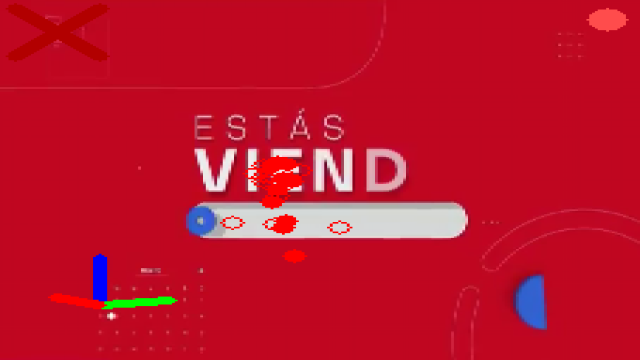

frame_9300.png





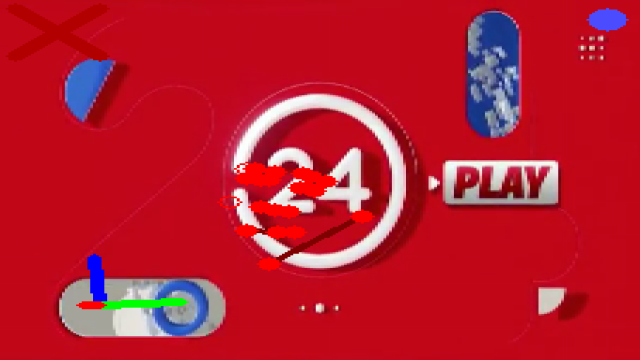

frame_8400.png





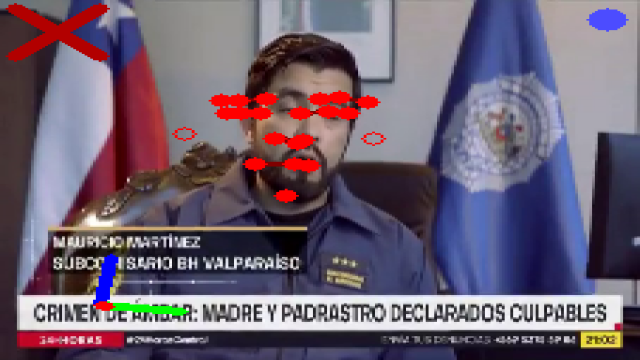

frame_9900.png





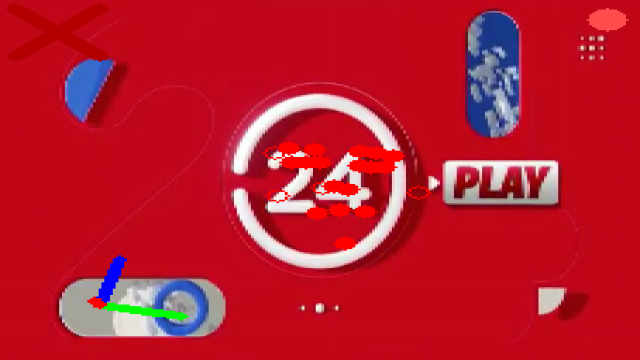

frame_9600.png





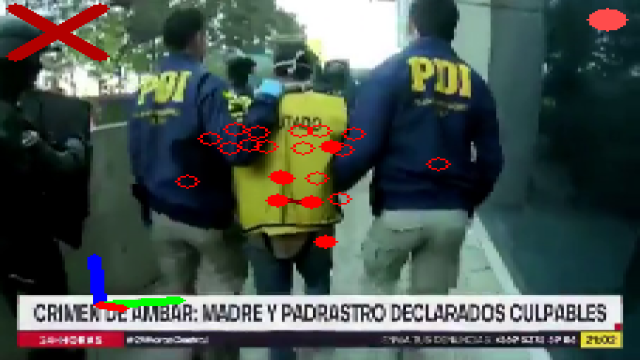

frame_10200.png





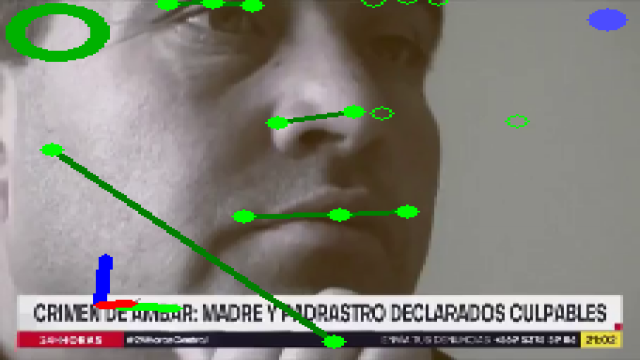

frame_10800.png





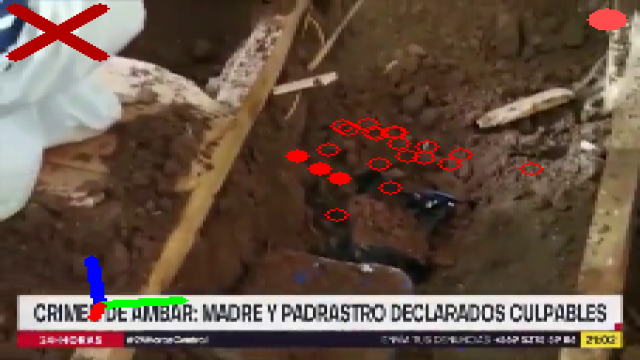

frame_11100.png





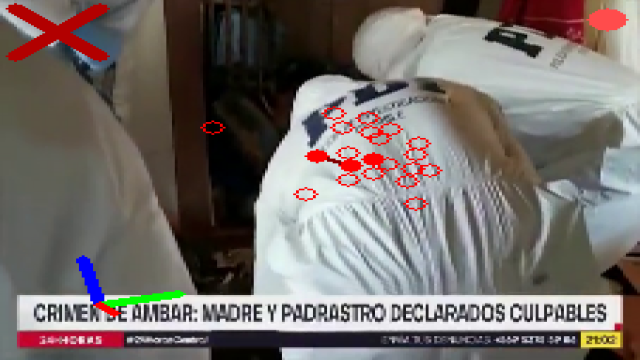

frame_11400.png





In [ ]:
for filename in os.listdir("/content/drive/MyDrive/ai/2021_11_26_22"):
    if not filename.endswith(".png"):
        continue
    img_path = os.path.join("/content/drive/MyDrive/ai/2021_11_26_22", filename)
    image_swapped = io.imread(f"{img_path}")
    image_2 = cv2.cvtColor(image_swapped, cv2.COLOR_BGR2RGB)
    image3 = frame_detect(image_2)
    cv2_imshow(image3)
    print(filename)
    print('\n\n')
